In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **0. 데이터 로드, text 전처리(정규식 노가다 / 불용어 제거)**
* 텍스트 전처리 - 정규식
> * text2 함수 -> 've, 'd 등 줄임표현 확인('s 제외). 
> * text1 함수 -> 's 확인('s의 경우 is를 줄인 것인지 소유격 표현인지 구분이 필요할 것 같아서 text1함수로 따로 체크). 확인 결과, 데이터를 일일이 소유격인지 is 줄임표현인지 구분하기 어려울거 같아서(nltk 알기 전,,), 일단 대명사's 꼴인 경우 is 줄인 것으로 간주, 대명사+is로 분해하기로 했다(nltk 알기 전).
> * preprocess_text 함수 -> 텍스트 전처리(줄임표현 분해 + 알파벳, ' 이외 문자는 공백 처리 + single word 제거 + 연속 공백은 공백 하나로 처리)
> ---
> * 전처리할 때 nltk를 추가적으로 사용해볼까 한다.

* 텍스트 전처리 - 불용어 제거
> * 시도하긴 해봤는데 문장 대부분이 사라진다.

* X, y 데이터 분리 -> train/test data 분리
> * X_train -> text data -> X_train, X_test
> * y_train -> 각 X에 대응되는 라벨 -> y_train, y_test

* 임베딩
> * 토큰화, 시퀀스화

### 텍스트 전처리(아직 부족한 부분이 많음)

In [ ]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/Parrot_teamproject/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Parrot_teamproject/test.csv')
test_label = pd.read_csv('/content/drive/MyDrive/Parrot_teamproject/test_labels.csv')

정규식

In [ ]:
import re
import pandas as pd

#'s 확인; is 줄임표현인지 소유격 표현인지 알아보려고 따로 실행
def text1(sen):
  sen = str(re.findall(r"\w+\'s", sen))
  return sen

#기타 줄임표현 확인 ex. 've, 'd, ...
def text2(sen):
  sen = str(re.findall(r'\w+\'\w+', sen))
  return sen

In [ ]:
#'s 확인
df1 = pd.DataFrame(train_df['comment_text'].apply(text1))
df1 = df1[df1['comment_text']!='[]']
df1

,comment_text
2,"[""It's""]"
3,"[""It's""]"
4,"[""that's""]"
8,"[""it's""]"
10,"[""file's"", ""website's"", ""website's""]"
...,...
159533,"[""What's"", ""that's""]"
159542,"[""he's"", ""it's""]"
159555,"[""it's"", ""That's"", ""ODB's""]"
159560,"[""there's"", ""here's"", ""What's""]"


In [ ]:
#기타 줄임표현 확인

#줄임표현 모두 df2에
df2 = pd.DataFrame(train_df['comment_text'].apply(text2))

#'s는 제외
df2 = df2[df2['comment_text'] != df2['comment_text'].apply(text1).values]
df2

,comment_text
0,"[""weren't"", ""don't"", ""I'm""]"
1,"[""D'aww"", ""I'm""]"
2,"[""I'm"", ""It's""]"
3,"[""can't"", ""It's""]"
7,"[""don't""]"
...,...
159556,"[""I'll""]"
159560,"[""there's"", ""I'll"", ""don't"", ""here's"", ""What's..."
159561,"[""Jimbo's"", ""can't"", ""don't"", ""it's"", ""Bishone..."
159566,"[""can't""]"


In [ ]:
#텍스트 전처리 함수.
import re

def preprocess_text(sen):
    
    # 글자 모두 lower
    sentence = sen.lower()

    # is 줄임표현 분해
    sentence = re.sub(r'it\'s', 'it is', sentence)
    sentence = re.sub(r'that\'s', 'that is', sentence)
    sentence = re.sub(r'he\'s', 'he is', sentence)
    sentence = re.sub(r'she\'s', 'she is', sentence)
    sentence = re.sub(r'here\'s', 'here is', sentence)
    sentence = re.sub(r'there\'s', 'there is', sentence)

    #기타 줄임표현 분해... 노가다,,
    sentence = re.sub(r"\'ve", " have ", sentence)
    sentence = re.sub(r"can't", "can not ", sentence)
    sentence = re.sub(r"n't", " not ", sentence)
    sentence = re.sub(r"i'm", "i am ", sentence)
    sentence = re.sub(r"\'re", " are ", sentence)
    sentence = re.sub(r"\'d", " would ", sentence)
    sentence = re.sub(r"\'ll", " will ", sentence)
    sentence = re.sub(r"\'scuse", " excuse ", sentence)
    sentence = re.sub('\W', ' ', sentence)  

    # 알파벳, ' 빼고 다 공백으로 바꿈
    sentence = re.sub('[^a-z\']', ' ', sentence)

    # single word 제거
    sentence = re.sub(r"\s+[a-z]\s+", ' ', sentence)

    # 공백 연속적으로 나타날 경우 공백 하나로 바꿈
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

불용어 제거
**공익을 위한 실패경험담 공유**

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train_x = train_df['comment_text']
test_x = test_df['comment_text']
train_y = train_df[labels].values

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
for idx, string in enumerate(train_x):
    words = word_tokenize(string)
    clean_train_x = []
    for word in words:
        word = word.lower() #대소문자 구별 무시하도록 소문자로 통일
        if word not in stop_words: #불용어 제거
            clean_train_x.append(word)

In [ ]:
print(clean_train_x[:10])

['``', '...', 'really', "n't", 'think', 'understand', '.', 'came', 'idea', 'bad']


    ['``', '...', 'really', "n't", 'think', 'understand', '.', 'came', 'idea', 'bad']

In [ ]:
for idx, string in enumerate(test_x):
    words = word_tokenize(string)
    clean_test_x = []
    for word in words:
        word = word.lower() #대소문자 구별 무시하도록 소문자로 통일
        if word not in stop_words: #불용어 제거
            clean_test_x.append(word)

In [ ]:
print(clean_test_x[:10])

['``', ':', ':', ':', 'stop', 'already', '.', 'bullshit', 'welcome', '.']


    ['``', ':', ':', ':', 'stop', 'already', '.', 'bullshit', 'welcome', '.'

In [ ]:
print(len(clean_train_x))

30


    30

In [ ]:
print(len(train_x))

159571


    159571

### X, y 데이터 분리 -> train/test data 분리

In [ ]:
#X : '소문자 단어 + 공백 하나'로만 구성된 text data
X = []
sentences = list(train_df["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

#y : 소속된 라벨 나타내는 벡터를 원소로 갖는 array; ex) element [1, 0, 0, 1, 0, 0] => 1번쨰, 4번째 라벨 소속된 sentence
y = train_df[train_df.columns[2:]].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

### 임베딩

In [ ]:
max_words = 25000
max_len = 200
embedding_dim = 128

In [ ]:
#토큰화, sequence화
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen=max_len) #뒤쪽 패딩
X_test = pad_sequences(X_test, padding='post', maxlen=max_len) #뒤쪽 패딩

In [ ]:
num_classes = 6

# **1. 모델링**
* pretrained glove 이용
> * 설정:
    * max_len = 200개 이후의 단어는 버림
    * max_words = 데이터셋에서 가장 빈도 높은 4만 개의 단어만 사용
    * embedding_dim = 128차원 벡터
    * batch_size = 128 (64이하는 너무 오래걸림)
    * epoch = 2
    * validation_split = 0.2
> ---
  * model1. LSTM만 쌓은 모델
  * model2. Bidirectional LSTM - LSTM

* 층 쌓기
> * 설정:
    * max_len = 150개 이후의 단어는 버림
    * max_words = 데이터셋에서 가장 빈도 높은 1만 개의 단어만 사용
    * embedding_dim = 128차원 벡터
    * batch_size = 128 (64이하는 너무 오래걸림)
    * epoch = 10
    * validation_split = 0.2
    * early_stopping = patience가 2, 기준은 accuracy
> ---
  * model3. Bidirectional LSTM
  * model4. LeakyReLU

In [ ]:
import matplotlib.pyplot as plt

def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

### model1. glove + LSTM->LSTM

In [ ]:
from numpy import array, asarray, zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/Parrot_teamproject/glove.6B.100d.txt.zip (Unzipped Files)/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input

model1 = Sequential()
model1.add(Input(shape=(max_len,)))
model1.add(Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False))
model1.add(LSTM(units = 128, dropout = 0.2, return_sequences = True))
model1.add(LSTM(units = 64, dropout = 0.2))
model1.add(Dense(6, activation='sigmoid'))

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          14843700  
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 128)          117248    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 15,010,746
Trainable params: 167,046
Non-trainable params: 14,843,700
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', mode='min', patience = 2)

In [ ]:
history = model1.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split = 0.2, shuffle = True, callbacks = [early_stopping])

Epoch 1/10
798/798 [==============================] - 29s 33ms/step - loss: 0.1732 - acc: 0.8822 - val_loss: 0.1331 - val_acc: 0.9936
Epoch 2/10
798/798 [==============================] - 26s 32ms/step - loss: 0.1359 - acc: 0.9939 - val_loss: 0.1076 - val_acc: 0.9936
Epoch 3/10
798/798 [==============================] - 25s 32ms/step - loss: 0.0987 - acc: 0.9941 - val_loss: 0.0673 - val_acc: 0.9935
Epoch 4/10
798/798 [==============================] - 26s 32ms/step - loss: 0.0679 - acc: 0.9937 - val_loss: 0.0622 - val_acc: 0.9937
Epoch 5/10
798/798 [==============================] - 26s 32ms/step - loss: 0.0638 - acc: 0.9933 - val_loss: 0.0590 - val_acc: 0.9937
Epoch 6/10
798/798 [==============================] - 25s 32ms/step - loss: 0.0608 - acc: 0.9940 - val_loss: 0.0574 - val_acc: 0.9937
Epoch 7/10
798/798 [==============================] - 25s 32ms/step - loss: 0.0593 - acc: 0.9942 - val_loss: 0.0558 - val_acc: 0.9937
Epoch 8/10
798/798 [==============================] - 25s 32ms

In [ ]:
score = model1.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 10s 10ms/step - loss: 0.0533 - acc: 0.9946
Test Score: 0.05328445881605148
Test Accuracy: 0.9946106672286987


    Test Score: 0.061449188739061356
    Test Accuracy: 0.9946106672286987

### model2. glove + Bidirectional LSTM->LSTM

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/Parrot_teamproject/glove.6B.100d.txt.zip (Unzipped Files)/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
#model2
from tensorflow.keras.layers import Bidirectional, GRU

model2 = Sequential()
model2.add(Input(shape=(max_len,)))
model2.add(Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False))
model2.add(Bidirectional(LSTM(units = 128, dropout = 0.2, return_sequences = True)))
model2.add(LSTM(units = 128, dropout = 0.2))
model2.add(Dense(6, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model2.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2, shuffle = True, callbacks = [early_stopping])

Epoch 1/10
798/798 [==============================] - 53s 62ms/step - loss: 0.1669 - acc: 0.9143 - val_loss: 0.1369 - val_acc: 0.9924
Epoch 2/10
798/798 [==============================] - 48s 60ms/step - loss: 0.1297 - acc: 0.9931 - val_loss: 0.1255 - val_acc: 0.9936
Epoch 3/10
798/798 [==============================] - 48s 60ms/step - loss: 0.1309 - acc: 0.9932 - val_loss: 0.0680 - val_acc: 0.9935
Epoch 4/10
798/798 [==============================] - 48s 60ms/step - loss: 0.0670 - acc: 0.9942 - val_loss: 0.0571 - val_acc: 0.9928
Epoch 5/10
798/798 [==============================] - 48s 60ms/step - loss: 0.0574 - acc: 0.9937 - val_loss: 0.0536 - val_acc: 0.9937
Epoch 6/10
798/798 [==============================] - 48s 60ms/step - loss: 0.0528 - acc: 0.9943 - val_loss: 0.0520 - val_acc: 0.9937
Epoch 7/10
798/798 [==============================] - 48s 60ms/step - loss: 0.0507 - acc: 0.9944 - val_loss: 0.0493 - val_acc: 0.9936
Epoch 8/10
798/798 [==============================] - 48s 60ms

In [ ]:
score = model2.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 14s 14ms/step - loss: 0.0473 - acc: 0.9943
Test Score: 0.04734727367758751
Test Accuracy: 0.9942973256111145


    Test Score: 0.13958047330379486
    Test Accuracy: 0.9946106672286987

### model3. Bidirectional LSTM

In [ ]:
from tensorflow.keras.preprocessing import sequence

tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(list(train_x))

train_x = tok.texts_to_sequences(train_x)
test_x = tok.texts_to_sequences(test_x)

train_x = sequence.pad_sequences(train_x, maxlen = max_len)
test_x = sequence.pad_sequences(test_x, maxlen = max_len)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.layers import GRU, Conv1D, MaxPooling1D, Flatten, BatchNormalization, GlobalAveragePooling1D, AveragePooling1D, Average, GlobalMaxPooling1D

In [ ]:
def model_LSTM(num_classes):
    inp = Input(shape = (max_len, ))
    layer = Embedding(max_words, embedding_dim)(inp)
    layer = Bidirectional(LSTM(50, return_sequences = True, recurrent_dropout = 0.15))(layer)
    layer = GlobalMaxPool1D()(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(50, activation = 'relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(num_classes, activation = 'sigmoid')(layer)
    model = Model(inputs = inp, outputs = layer)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [ ]:
model_3 = model_LSTM(num_classes)
model_3.summary()

# 찾아보니 이 부분 warning은 오류라기 보단 텐서플로에서 LSTM이 느리니까 빠르게 돌아갈 수 있는 디폴트 파라미터들을 정해놨는데 제가 마음대로 recurrent_dropout 값을 조정해버려서 이렇더라고요
# 그래서 느리긴 하지만 돌아가는데 문제는 없습니다!

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 128)          3200000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 100)          71600     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [ ]:
hist_3 = model_3.fit(train_x, train_y, batch_size = 128, epochs = 10, validation_split=0.2, shuffle=True, callbacks = [early_stopping])

Epoch 1/10
998/998 [==============================] - 1167s 1s/step - loss: 0.0832 - accuracy: 0.8406 - val_loss: 0.0496 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 1130s 1s/step - loss: 0.0474 - accuracy: 0.9806 - val_loss: 0.0491 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 1145s 1s/step - loss: 0.0423 - accuracy: 0.9797 - val_loss: 0.0497 - val_accuracy: 0.9941
Epoch 4/10
998/998 [==============================] - 1164s 1s/step - loss: 0.0382 - accuracy: 0.9751 - val_loss: 0.0520 - val_accuracy: 0.9940


    Epoch 1/10
    998/998 [==============================] - 787s 784ms/step - loss: 0.1468 - accuracy: 0.7118 - val_loss: 0.0513 - val_accuracy: 0.9941
    Epoch 2/10
    998/998 [==============================] - 792s 794ms/step - loss: 0.0504 - accuracy: 0.9821 - val_loss: 0.0499 - val_accuracy: 0.9941
    Epoch 3/10
    998/998 [==============================] - 784s 785ms/step - loss: 0.0456 - accuracy: 0.9813 - val_loss: 0.0503 - val_accuracy: 0.9941


In [ ]:
acc_loss_plot(hist_3)

NameError: ignored

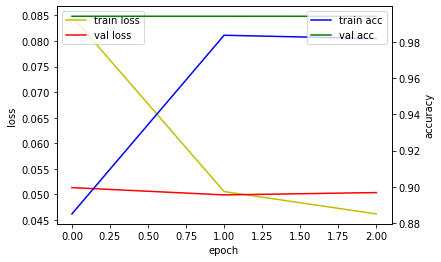

## model4.CNN+GRU

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def model_GRU(num_classes):
    inp = Input(shape = (max_len, ))
    layer = Embedding(max_words, embedding_dim)(inp)
    layer = Conv1D(64, 5, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling1D(3)(layer)
    later = Conv1D(64, 5, padding='same', activation='relu')(layer)
    layer = GRU(128, dropout=0.2, recurrent_dropout=0.2)(layer)
    layer = Dense(64, activation='relu')(layer)
    layer = Dropout(0.3)(layer)
    layer = Dense(num_classes, activation = 'sigmoid')(layer)
    model = Model(inputs = inp, outputs = layer)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [ ]:
model_4 = model_GRU(num_classes)
model_4.summary()

In [ ]:
hist_4 = model_4.fit(train_x, train_y, batch_size = 128, epochs = 10, validation_split=0.20, shuffle=True, callbacks = [early_stopping])

In [ ]:
acc_loss_plot(hist_4)

### model5. LeakyReLU

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.layers import LeakyReLU

def model_CNN_2(num_classes):
  inp = Input(shape = (max_len, ))
  layer = Embedding(max_words, embedding_dim)(inp)

  layer = Conv1D(64, 3, padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = LeakyReLU(alpha=0.1)(layer)

  layer = Conv1D(64, 3, padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = LeakyReLU(alpha=0.1)(layer)

  layer = Conv1D(64, 3, padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = LeakyReLU(alpha=0.1)(layer)

  layer = Conv1D(64, 3, padding='same')(layer)
  layer = BatchNormalization()(layer)
  layer = LeakyReLU(alpha=0.1)(layer)

  layer = Flatten()(layer)
  layer = Dense(64, activation='relu')(layer)
  layer = Dropout(0.3)(layer)
  layer = Dense(num_classes, activation = 'softmax')(layer)
  model = Model(inputs = inp, outputs = layer)
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
  return model

In [ ]:
model_5 = model_CNN_2(num_classes)
model_5.summary()

In [ ]:
hist_5 = model_5.fit(train_x, train_y, batch_size = 128, epochs = 5, validation_split=0.20, shuffle=True)

    Epoch 1/5
    998/998 [==============================] - 27s 26ms/step - loss: 0.1215 - accuracy: 0.6051 - val_loss: 0.0643 - val_accuracy: 0.9941
    Epoch 2/5
    998/998 [==============================] - 24s 24ms/step - loss: 0.0536 - accuracy: 0.9279 - val_loss: 0.0570 - val_accuracy: 0.9941
    Epoch 3/5
    998/998 [==============================] - 24s 24ms/step - loss: 0.0468 - accuracy: 0.9493 - val_loss: 0.0608 - val_accuracy: 0.9933
    Epoch 4/5
    998/998 [==============================] - 24s 24ms/step - loss: 0.0398 - accuracy: 0.9589 - val_loss: 0.0902 - val_accuracy: 0.9931
    Epoch 5/5
    998/998 [==============================] - 24s 24ms/step - loss: 0.0364 - accuracy: 0.9565 - val_loss: 0.0682 - val_accuracy: 0.9941

In [ ]:
acc_loss_plot(hist_5)

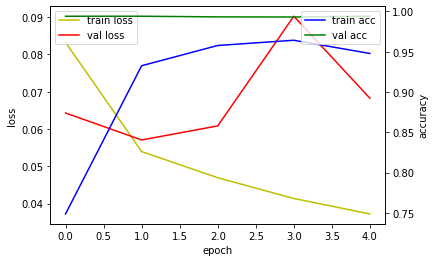